In [1]:
%matplotlib inline
import os, glob
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Compare turbine models
with turbine measurements from `process_turbine_output.ipynb`

Available measurements:
- generator power
- generator torque
- rotor RPM

In [2]:
refdatadir = '/Users/equon/WakeDynamics/wakebench_swift/wt_data/measurements'
modeldir = '/Users/equon/WakeDynamics/wakebench_wtg_response'
dirprefix = 'WAKEBENCH-'
simtypes = ['SSAM','RANS','DWMT','LES']

In [3]:
cases = {
    'neutral': '#008F00',
    'stable': '#003C60',
    'unstable': '#890001',
}

In [4]:
# output data names
RotPwr = 'rotor_power_[kW]'
GenPwr = 'generator_power_[kW]'
GenTq = 'generator_torque_[N_m]'
RotSpd = 'rotor_speed_[rpm]'
Thrust = 'aero_thrust_force_[N]'

In [5]:
GenEff = 0.96349  # for converting from rotor power to generator power

## catalog available model results

In [6]:
dirs = glob.glob(os.path.join(modeldir,dirprefix+'*'))

In [7]:
dirpaths = {os.path.split(dpath)[1][len(dirprefix):]: dpath for dpath in dirs}
dirpaths

{'NREL_SHALER_DWMT-LES': '/Users/equon/WakeDynamics/wakebench_wtg_response/WAKEBENCH-NREL_SHALER_DWMT-LES',
 'IFPEN_CATHELAIN_SSAM': '/Users/equon/WakeDynamics/wakebench_wtg_response/WAKEBENCH-IFPEN_CATHELAIN_SSAM',
 'NREL_DEBNATH_LES': '/Users/equon/WakeDynamics/wakebench_wtg_response/WAKEBENCH-NREL_DEBNATH_LES',
 'IFPEN_CATHELAIN_LES': '/Users/equon/WakeDynamics/wakebench_wtg_response/WAKEBENCH-IFPEN_CATHELAIN_LES',
 'DTU_VANDERLAAN_RANS-MOST': '/Users/equon/WakeDynamics/wakebench_wtg_response/WAKEBENCH-DTU_VANDERLAAN_RANS-MOST',
 'DTU_ANDERSEN_LES': '/Users/equon/WakeDynamics/wakebench_wtg_response/WAKEBENCH-DTU_ANDERSEN_LES',
 'DTU_VANDERLAAN_RANS-ABL': '/Users/equon/WakeDynamics/wakebench_wtg_response/WAKEBENCH-DTU_VANDERLAAN_RANS-ABL',
 'PPEGmbH_SCHLEZ_RANS': '/Users/equon/WakeDynamics/wakebench_wtg_response/WAKEBENCH-PPEGmbH_SCHLEZ_RANS',
 'FORWIND_KRUEGER_LES': '/Users/equon/WakeDynamics/wakebench_wtg_response/WAKEBENCH-FORWIND_KRUEGER_LES',
 'NREL_SHALER_DWMT': '/Users/equon/W

In [8]:
availsimtypes = []
for name in dirpaths.keys():
    simtype = name.split('_')[-1]
    simtype = simtype.split('-')[0]
    print(name,simtype)
    if simtype not in availsimtypes:
        availsimtypes.append(simtype)
print('Simulation types:',availsimtypes)
for simtype in simtypes:
    availsimtypes.remove(simtype)
assert(len(availsimtypes) == 0), 'simtypes list is incomplete'

NREL_SHALER_DWMT-LES DWMT
IFPEN_CATHELAIN_SSAM SSAM
NREL_DEBNATH_LES LES
IFPEN_CATHELAIN_LES LES
DTU_VANDERLAAN_RANS-MOST RANS
DTU_ANDERSEN_LES LES
DTU_VANDERLAAN_RANS-ABL RANS
PPEGmbH_SCHLEZ_RANS RANS
FORWIND_KRUEGER_LES LES
NREL_SHALER_DWMT DWMT
SNL_MANIACI_LES LES
NREL_MARTINEZ_LES LES
Simulation types: ['DWMT', 'SSAM', 'LES', 'RANS']


In [9]:
sims_of_type = {}
for simtype in simtypes:
    sims_of_type[simtype] = []
    for name in dirpaths.keys():
        suffix = name.split('_')[-1]
        if suffix.startswith(simtype):
            sims_of_type[simtype].append(name)
for simtype in simtypes:
    sims_of_type[simtype].sort()
print(sims_of_type)

{'SSAM': ['IFPEN_CATHELAIN_SSAM'], 'RANS': ['DTU_VANDERLAAN_RANS-ABL', 'DTU_VANDERLAAN_RANS-MOST', 'PPEGmbH_SCHLEZ_RANS'], 'DWMT': ['NREL_SHALER_DWMT', 'NREL_SHALER_DWMT-LES'], 'LES': ['DTU_ANDERSEN_LES', 'FORWIND_KRUEGER_LES', 'IFPEN_CATHELAIN_LES', 'NREL_DEBNATH_LES', 'NREL_MARTINEZ_LES', 'SNL_MANIACI_LES']}


## load all data

In [10]:
def load_turbine_output(dpath,case):
    flist = glob.glob(os.path.join(dpath,case,'*'))
    print(dpath)
    if len(flist) == 0:
        print('  NO SUBMISSIONS FOUND')
        return None
    data = []
    for fpath in flist:
        print('  reading',os.path.split(fpath)[1])
        df = pd.read_csv(fpath, comment='#')
        if df.columns[0] == 'time_[s]':
            # have a time series
            df = df.set_index('time_[s]')
            assert (RotPwr in df.columns)
            assert (GenPwr in df.columns)
            assert (GenTq in df.columns)
            assert (RotSpd in df.columns)
            if np.all(pd.isna(df[GenPwr])):
                # IFPEN_CATHELAIN_LES fix
                print('  ***generator power unavailable, estimating from rotor power***')
                df[GenPwr] = df[RotPwr] * GenEff
            if Thrust not in df.columns:
                # NREL_DEBNATH_LES fix
                # if thrust_force is available, then assume that's the aero_thrust_force
                assert ('thrust_force_[N]' in df.columns)
                print('  ***renaming thrust_force_[N]***')
                df.rename(columns={'thrust_force_[N]': Thrust}, inplace=True)
            data.append(df)
        elif df.columns[0] == 'name':
            # have steady-state values
            df = df.set_index('name')
            assert (RotPwr in df.index)
            assert (Thrust in df.index)
            if (GenPwr not in df.index) or np.isnan(df.loc[GenPwr].value):
                print('  ***generator power unavailable, estimating from rotor power***')
                df.loc[GenPwr] = df.loc[RotPwr] * GenEff
            data.append(df)
    return data

In [11]:
turbinedata = {}
for cond in cases.keys():
    print('\n'+cond)
    print(len(cond)*'-')
    turbinedata[cond] = {}
    for name,dpath in dirpaths.items():
        data = load_turbine_output(dpath,cond)
        if data is not None:
            turbinedata[cond][name] = data


neutral
-------
/Users/equon/WakeDynamics/wakebench_wtg_response/WAKEBENCH-NREL_SHALER_DWMT-LES
  reading NREL_SHALER_DWMT_LES_20190931_wtg_response_Neutral.txt
/Users/equon/WakeDynamics/wakebench_wtg_response/WAKEBENCH-IFPEN_CATHELAIN_SSAM
  reading IFPEN_CATHELAIN_SSAM_20190808_wtg_response_steady_state.txt
  ***generator power unavailable, estimating from rotor power***
/Users/equon/WakeDynamics/wakebench_wtg_response/WAKEBENCH-NREL_DEBNATH_LES
  reading NREL_DEBNATH_LES_20190830_wtg_response.txt
  ***renaming thrust_force_[N]***
/Users/equon/WakeDynamics/wakebench_wtg_response/WAKEBENCH-IFPEN_CATHELAIN_LES
  reading IFPEN_CATHELAIN_LES_20190830_wtg_response_t0_to600s.txt
  ***generator power unavailable, estimating from rotor power***
/Users/equon/WakeDynamics/wakebench_wtg_response/WAKEBENCH-DTU_VANDERLAAN_RANS-MOST
  reading DTU_VANDERLAAN_RANS-MOST_20190910_wtg_response_steady_state.txt
/Users/equon/WakeDynamics/wakebench_wtg_response/WAKEBENCH-DTU_ANDERSEN_LES
  reading DTU_AN

In [12]:
refdata = {
    cond: pd.read_csv(os.path.join(refdatadir,cond+'_bootstrap_stats.csv'),index_col=0
                      ).rename(index={'GenPwr':GenPwr,'GenTq':GenTq,'rotorRPM':RotSpd})
    for cond in cases.keys()
}

## plots

IFPEN_CATHELAIN_SSAM neutral 86.03098559
DTU_VANDERLAAN_RANS-ABL neutral 91.77773
DTU_VANDERLAAN_RANS-MOST neutral 91.94721
PPEGmbH_SCHLEZ_RANS neutral 89.95784966666668
NREL_SHALER_DWMT neutral 86.56139527165632
NREL_SHALER_DWMT-LES neutral 91.39848701434157
DTU_ANDERSEN_LES neutral 94.45007866456916
FORWIND_KRUEGER_LES neutral 81.10110569136934
IFPEN_CATHELAIN_LES neutral 102.92192135834391
NREL_DEBNATH_LES neutral 101.56177563678915
NREL_MARTINEZ_LES neutral 95.32061732818924
SNL_MANIACI_LES neutral 99.96513989512621
IFPEN_CATHELAIN_SSAM stable 15.2905863
DTU_VANDERLAAN_RANS-ABL stable 15.4315
DTU_VANDERLAAN_RANS-MOST stable 15.90177
PPEGmbH_SCHLEZ_RANS stable 15.977875833333334
NREL_SHALER_DWMT stable 14.828547922049532
NREL_SHALER_DWMT-LES stable 14.698944609154314
NREL_DEBNATH_LES stable 15.393207998981282
IFPEN_CATHELAIN_SSAM unstable 42.43884403
DTU_VANDERLAAN_RANS-ABL unstable 41.17563
DTU_VANDERLAAN_RANS-MOST unstable 40.88967
NREL_SHALER_DWMT unstable 40.33244366889732
NREL_

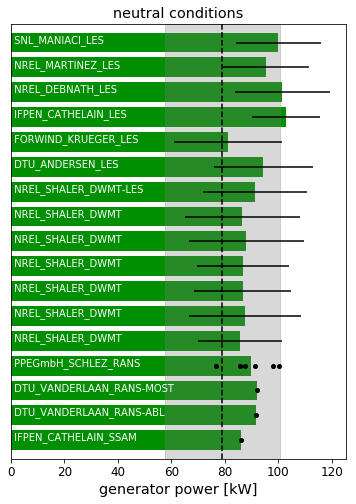

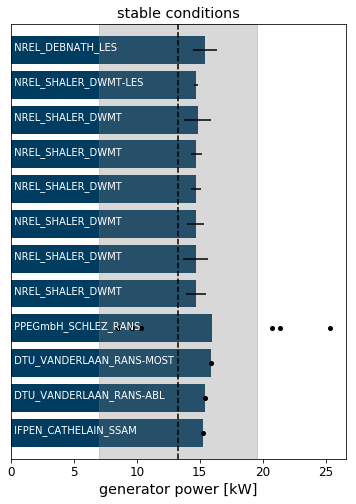

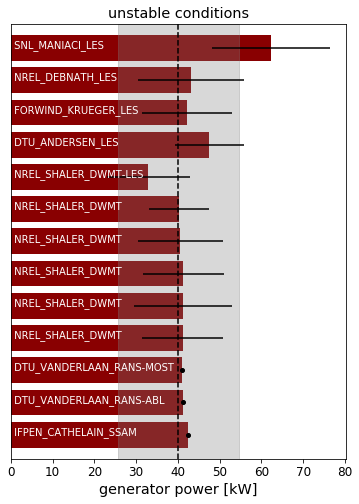

In [13]:
output = GenPwr

for cond in cases.keys():

    avail = turbinedata[cond]
    Nresults = len(avail.keys())
    irow = 0
    fig,ax = plt.subplots(figsize=(6,8))
    for simtype in simtypes:
        for name in sims_of_type[simtype]:
            if name in avail.keys():
                #print(name,cond)
                data = turbinedata[cond][name]
                if data[0].index.name == 'time_[s]':
                    # list of time histories of all quantities
                    for df in data:
                        # calculate stats
                        mean = df[output].mean()
                        err = df[output].std()
                        ax.barh(irow, mean, xerr=err, color=cases[cond])
                        ax.text(0,irow,' '+name,color='w')
                        irow += 1
                else:
                    # list of steady-state power values
                    data = [df.loc[output] for df in data]
                    mean = np.mean(data)
                    ax.barh(irow, mean, color=cases[cond])
                    ax.plot(data, len(data)*[irow], 'ko', markersize=4)
                    ax.text(0,irow,' '+name,color='w')
                    irow += 1
                print(name,cond,mean)

    refmean = refdata[cond].loc[output]['mean']
    referr = refdata[cond].loc[output]['stdev']
    ax.axvline(refmean, color='k', ls='--')
    ax.axvspan(refmean-referr, refmean+referr, color='0.5', alpha=0.3)

    ax.tick_params(axis='y',width=0,labelleft=False)
    ax.tick_params(labelsize='large')
    ax.set_ylim((-0.75,irow-0.25))
    ax.set_xlabel(output.replace('_',' '), fontsize='x-large')
    ax.set_title(cond+' conditions', fontsize='x-large')

    fig.savefig('compare_{:s}_{:s}.png'.format(output,cond))